In [488]:
import subprocess

import arrow
import pandas as pd
from bs4 import BeautifulSoup
from path_helpers import path

def get_summary(soup):
    def find_seq_id(tag):
        return tag.name == u'div' and tag.decode().find('SEQ-ID') >=0

    def find_account_summary(tag):
        return tag.name == u'span' and tag.decode().find('Your Account Summary') >=0

    def is_number(s):
        """Returns True if string is a number."""
        return s.replace('.','',1).isdigit()                

    def format_fields(input_list):
        fields = [x.strip(':') for x in input_list if x.find('</br>') == -1]
        return [float(x) if is_number(x) else x for x in fields]

    summary_fields = format_fields(soup.find_all(find_account_summary)[0].contents)
    summary_data = format_fields(soup.find_all(find_seq_id)[0].next_sibling.contents[0].contents)
    return dict(zip(summary_fields[1:], summary_data))

def get_water_consumption(soup):
    def find_total_consumption(tag):
        return tag.name == u'div' and tag.decode().find('Total Consumption') >= 0

    water_div = soup.find_all(find_total_consumption)[0]
    water_fields = format_fields(water_div.contents[0].contents)
    water_data = format_fields(water_div.next_sibling.next_sibling.contents[0].contents)
    return dict(zip(water_fields, water_data))

def get_water_and_sewer_charges(soup):
    def find_water_consumption(tag):
        return tag.name == u'div' and tag.decode().find('Consumption') >=0 and tag.decode().find('Total Consumption') == -1

    water_div = soup.find_all(find_consumption)[0]
    water_type = format_fields(water_div.next_sibling.contents[0])

    result = {u'Time period': water_type[0]}
    water_type = water_type[1:]
    
    consumption = format_fields(water_div.next_sibling.next_sibling.contents[0])
    rates = format_fields(water_div.next_sibling.next_sibling.next_sibling.next_sibling.contents[0])
    charges = format_fields(water_div.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling.contents[0])
    
    for x in range(len(water_type)):
        result[water_type[x]] = {u'Consumption': consumption[x],
                                 u'Rate': rates[x],
                                 u'Charges': charges[x]}
    return result

def get_water_charges(soup):
    data = get_water_and_sewer_charges(soup)
    types = ['Water', 'Sewer']
    return dict(zip(types, [data[x]['Charges'] for x in types]))

def get_water_rates(soup):
    data = get_water_and_sewer_charges(soup)
    types = ['Water', 'Sewer']
    return dict(zip(types, [data[x]['Rate'] for x in types]))

def get_gas_consumption(soup):        
    gas_div = soup.find_all(find_total_consumption)[1]
    gas_fields = format_fields(gas_div.contents[0].contents)
    gas_data = format_fields(gas_div.next_sibling.next_sibling.contents[0].contents)
    return dict(zip(gas_fields, gas_data))

def get_gas_charges(soup):
    def find_gas_rates(tag):
        return tag.name == u'div' and tag.decode().find('Gas Fixed Delivery Charge') >=0

    gas_div = soup.find_all(find_gas_rates)[0]

    gas_fields = format_fields(gas_div.contents[0])
    result = {u'Time period': gas_fields[0]}
    
    gas_fields = gas_fields[1:]
    gas_rates = format_fields(gas_div.next_sibling.next_sibling.next_sibling.contents[0])
    gas_charges = format_fields(gas_div.next_sibling.next_sibling.next_sibling.next_sibling.contents[0])
        
    result.update(dict(zip(gas_fields, gas_charges)))
    return result
        
def get_gas_rates(soup):
    def find_gas_rates(tag):
        return tag.name == u'div' and tag.decode().find('Gas Fixed Delivery Charge') >=0

    gas_div = soup.find_all(find_gas_rates)[0]
    gas_fields = format_fields(gas_div.contents[0]) 
    gas_fields = gas_fields[1:]
    gas_rates = format_fields(gas_div.next_sibling.next_sibling.next_sibling.contents[0])
    gas_charges = format_fields(gas_div.next_sibling.next_sibling.next_sibling.next_sibling.contents[0])
    
    return dict(zip([x + ' Rate' for x in gas_fields if x.find('HST') == -1 and x.find('Fixed') == -1], gas_rates))

def process_pdf(pdf_file):
    html_file = path(pdf_file.namebase + '.html')
    subprocess.check_output(['python', '%CONDA_PREFIX%\Scripts\pdf2txt.py', '-o%s' % html_file, pdf_file.name], shell=True)

    with open(html_file, 'r') as f:
        soup = BeautifulSoup(f, 'html.parser')

    html_file.remove()
    summary = get_summary(soup)
    
    if 'Pre-authorized Withdrawal' in summary.keys():
        amount_due = summary['Pre-authorized Withdrawal']
    elif 'Total Due' in summary.keys():
        amount_due = summary['Total Due']
    else:
        print "Couldn't find amount due!"
        amount_due = None

    new_name = '%s-Kitchener utilities-$%s.pdf' % (arrow.get(summary['Issue Date'], 'MMM DD YYYY').format('YYYY-MM-DD'),
        amount_due)
    pdf_file.rename(new_name)
    
    return {'summary': summary,
            'water consumption': get_water_consumption(soup),
            #'water and sewer charges': get_water_and_sewer_charges(soup),
            'gas consumption': get_gas_consumption(soup),
            'gas charges': get_gas_charges(soup),
            'gas rates': get_gas_rates(soup)
           }
        
data = []
for pdf_file in path('.').glob('*.pdf'):
    print pdf_file
    data.append(process_pdf(pdf_file))

.\2017-09-18-Kitchener utilities-$49.09.pdf
.\2017-10-18-Kitchener utilities-$83.64.pdf
.\2017-11-16-Kitchener utilities-$101.10.pdf
.\2017-12-14-Kitchener utilities-$132.48.pdf
.\2018-01-17-Kitchener utilities-$210.39.pdf
.\2018-02-14-Kitchener utilities-$177.85.pdf
.\2018-03-15-Kitchener utilities-$139.86.pdf
.\2018-04-16-Kitchener utilities-$152.22.pdf
.\2018-05-16-Kitchener utilities-$125.11.pdf
.\2018-06-15-Kitchener utilities-$102.31.pdf
.\2018-07-17-Kitchener utilities-$91.19.pdf
.\2018-08-16-Kitchener utilities-$66.78.pdf
.\2018-09-17-Kitchener utilities-$70.57.pdf
.\2018-10-16-Kitchener utilities-$78.46.pdf
.\2018-11-16-Kitchener utilities-$131.02.pdf


,Account Number,Balance Forward,Gas & Water Charges,Total Due,Water consumption,Gas consumption
Issue Date,,,,,,
2017-09-18,110159085.0,45.20,49.09,94.29,5.0,23.0
2017-10-18,110159085.0,96.17,83.64,195.12,9.0,45.0
2017-11-16,110159085.0,197.10,101.10,310.69,8.0,NaN
2017-12-14,110159085.0,0.00,132.48,144.97,8.0,NaN
2018-01-17,110159085.0,0.00,197.90,210.39,8.0,NaN
2018-02-14,110159085.0,0.00,165.36,177.85,7.0,NaN
2018-03-15,110159085.0,0.00,127.37,139.86,NaN,NaN
2018-04-16,110159085.0,0.00,138.49,152.22,8.0,273.0
2018-05-16,110159085.0,0.00,111.38,125.11,9.0,141.0


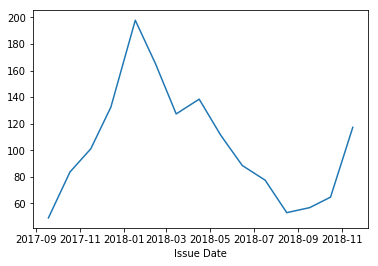

In [494]:
def convert_to_df(data):
    cols = data[0]['summary'].keys()
    if 'Pre-authorized Withdrawal' in cols:
        cols.remove('Pre-authorized Withdrawal')
        cols.append('Total Due')
    
    for x in data:
        if 'Pre-authorized Withdrawal' in x['summary'].keys():
            x['summary']['Total Due'] = x['summary']['Pre-authorized Withdrawal']
    data_sets = []
    for col in cols:
        data_sets.append([x['summary'][col] for x in data])
    return pd.DataFrame(data=dict(zip(cols, data_sets)))

df = convert_to_df(data)
df['Issue Date'] = [arrow.get(x, 'MMM DD YYYY').date() for x in df['Issue Date']]
df = df.set_index('Issue Date')

water_consumption = [x['water consumption']['Total Consumption'] if 'Total Consumption' in x['water consumption'] else None for x in data]
gas_consumption = [x['gas consumption']['Total Consumption'] if 'Total Consumption' in x['gas consumption'] else None for x in data]

df['Water consumption'] = water_consumption
df['Gas consumption'] = gas_consumption

df['Gas & Water Charges'].plot()
df